In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train BaggingClassifier as the ensemble model
meta_learner_bagging = BaggingClassifier(
    n_estimators=50,            # Number of base models
    max_samples=0.8,            # Fraction of the dataset for each model
    max_features=0.8,           # Fraction of features for each model
    bootstrap=True,             # Whether to bootstrap samples
    random_state=42             # For reproducibility
)
meta_learner_bagging.fit(stacked_features, y_test)

# Save the trained Bagging meta-learner
with open('meta_learner_bagging.pkl', 'wb') as file:
    pickle.dump(meta_learner_bagging, file)

# Predict using the Bagging meta-learner
final_predictions_bagging = meta_learner_bagging.predict(stacked_features)

# Evaluate the Bagging ensemble model
accuracy_bagging = accuracy_score(y_test, final_predictions_bagging)
report_bagging = classification_report(y_test, final_predictions_bagging, target_names=label_encoder.classes_)

print(f"Bagging Meta-Learner Accuracy: {accuracy_bagging * 100:.2f}%")
print("Classification Report (Bagging):\n", report_bagging)
print("Confusion Matrix (Bagging):\n", confusion_matrix(y_test, final_predictions_bagging))


581/581 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step
Bagging Meta-Learner Accuracy: 99.77%
Classification Report (Bagging):
               precision    recall  f1-score   support

     anxiety       1.00      1.00      1.00      1999
     bipolar       0.99      0.99      0.99      1941
  depression       1.00      1.00      1.00      1959
      normal       1.00      1.00      1.00     10679
        ptsd       1.00      1.00      1.00      1987

    accuracy                           1.00     18565
   macro avg       1.00      1.00      1.00     18565
weighted avg       1.00      1.00      1.00     18565

Confusion Matrix (Bagging):
 [[ 1992     3     2     0     2]
 [    1  1929     4     7     0]
 [    5     1  1952     0     1]
 [    1     9     0 10668     1]
 [    1     1     3     0  1982]]


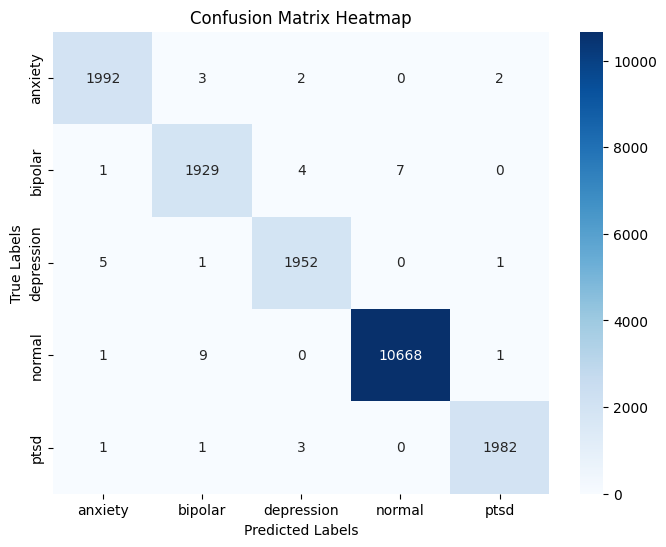

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, final_predictions_bagging)
class_labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


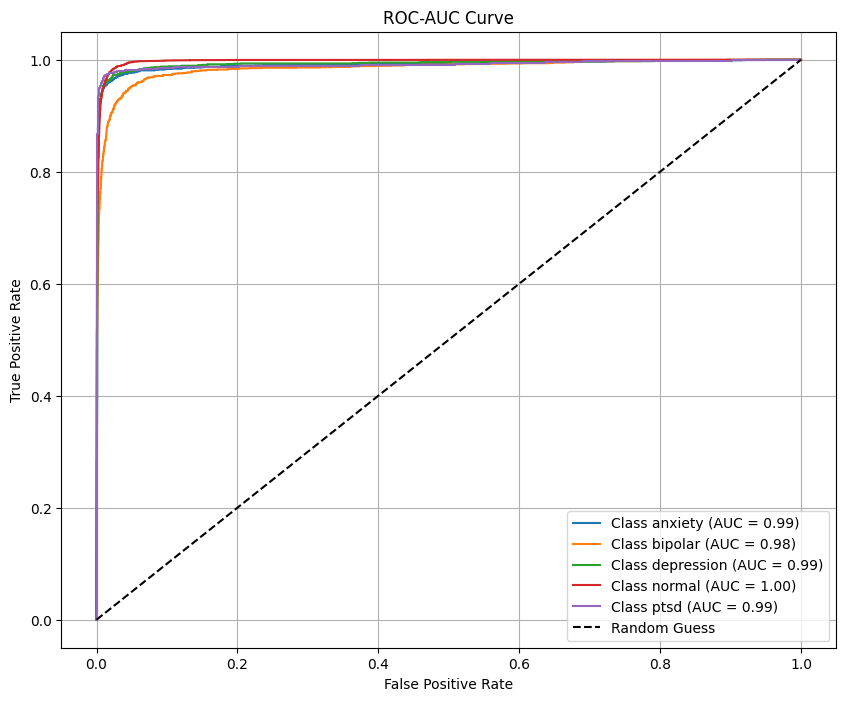

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multi-class ROC-AUC computation
y_test_binarized = label_binarize(y_test, classes=range(len(class_labels)))

# Initialize plot
plt.figure(figsize=(10, 8))

# Generate ROC curves for each class
for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
